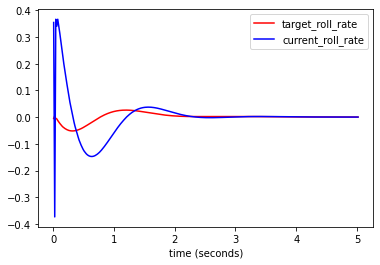

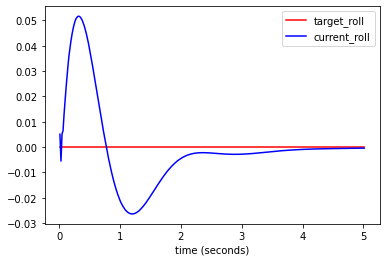

Done


In [16]:
import sys
sys.path.append("../../")

import math

from lib.data.dataplot import *
from lib.dds.dds import *
from lib.utils.time import *
from lib.system.controllers import *


class Multirotor:

    def __init__(self):
        self.vz_control = PID_Controller(5.0, 10.0, 0.0, 5)
        self.z_control = PID_Controller(2.0, 0.0, 0.0, 2)  # 2 m/s
        
        self.w_roll_control = PID_Controller(0.2, 0.5, 0.0, 2)
        self.roll_control = PID_Controller(1.0, 0.0, 0.0, 2) # max 2 rad/s

        self.w_pitch_control = PID_Controller(0.2, 0.5, 0.0, 2)
        self.pitch_control = PID_Controller(1.0, 0.0, 0.0, 2) # max 2 rad/s
        
        self.roll_target = math.radians(0)
        self.pitch_target = math.radians(-5)
        self.z_target = 1.0

    def evaluate(self, delta_t, z, vz, roll, roll_rate, pitch, pitch_rate):
        # propeller order
        #
        #  3     4
        #
        #  2     1
        #
        
        # altitude control
        self.vz_target = self.z_control.evaluate(delta_t, self.z_target - z)
        f = self.vz_control.evaluate(delta_t, self.vz_target - vz)
        
        # roll control
        self.roll_rate_target = self.roll_control.evaluate(delta_t, self.roll_target - roll)
        roll_command = self.w_roll_control.evaluate(delta_t, self.roll_rate_target - roll_rate)
        
        # pitch control
        self.pitch_rate_target = self.pitch_control.evaluate(delta_t, self.pitch_target - pitch)
        pitch_command = self.w_pitch_control.evaluate(delta_t, self.pitch_rate_target - pitch_rate)
        
        
        return f + roll_command - pitch_command, f - roll_command - pitch_command, \
                f - roll_command + pitch_command, f + roll_command + pitch_command

    
dpvz = DataPlotter()
dpvz.set_x("time (seconds)")
dpvz.add_y("target_roll_rate", "target_roll_rate")
dpvz.add_y("current_roll_rate", "current_roll_rate")

dpz = DataPlotter()
dpz.set_x("time (seconds)")
dpz.add_y("target_roll", "target_roll")
dpz.add_y("current_roll", "current_roll")

dds = DDS()
dds.start()

dds.subscribe(['tick', 'X', 'Y', 'Z', 'TX', 'TY', 'TZ', 'VX', 'VY', 'VZ', 'WX', 'WY', 'WZ'])

robot = Multirotor()

t = Time()
t.start()
while t.get() < 5:
    
    dds.wait('tick')    
    delta_t = t.elapsed()
    
    z = dds.read('Z')
    vz = dds.read('VZ')
    
    roll = dds.read('TX')
    roll_rate = dds.read('WX')
    
    pitch = dds.read('TY')
    pitch_rate = dds.read('WY')
    
    (f1, f2, f3, f4) = robot.evaluate(delta_t, z, vz, roll, roll_rate, pitch, pitch_rate)
    
    dds.publish('f1', f1, DDS.DDS_TYPE_FLOAT)
    dds.publish('f2', f2, DDS.DDS_TYPE_FLOAT)
    dds.publish('f3', f3, DDS.DDS_TYPE_FLOAT)
    dds.publish('f4', f4, DDS.DDS_TYPE_FLOAT)
    
    dpvz.append_x(t.get())
    dpvz.append_y("target_roll_rate", robot.roll_rate_target)
    dpvz.append_y("current_roll_rate", roll_rate)

    dpz.append_x(t.get())
    dpz.append_y("target_roll", robot.roll_target)
    dpz.append_y("current_roll", roll)


dds.stop()
dpvz.plot()
dpz.plot()

print("Done")